In [ ]:
!pip install setuptools==64.0.2
!apt-get install swig
!pip install wrds
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
cvxpy 1.3.1 requires setuptools>65.5.1, but you have setuptools 64.0.2 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installe

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [ ]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
import requests
from gensim import corpora, similarities
from textblob import TextBlob
from bs4 import BeautifulSoup

In [ ]:
UNWANTED_CHARS = ['ï»¿', 'â', 'ð§']


def filter_headline(content):

    # Remove special characters
    for i in UNWANTED_CHARS:
        content = content.replace(i, '')

    # Remove question headline and single quote
    return '' \
        if content[int(len(content)) - 1] == '?' \
        else content[1: int(len(content)) - 1] \
        if content[0] and content[int(len(content)) - 1] == "'" else content


def headline_extraction(url, webpage_inspect, webpage_class_inspect, headline_inspect, headline_class_inspect,
                        additional_words_inspect, additional_words_class_inspect, IsUnwanted):
    NEWS = []
    request_text = requests.get(url).text
    soup = BeautifulSoup(request_text, 'lxml')
    webpage = soup.find_all(webpage_inspect, webpage_class_inspect)
    for news in webpage:
        headline = news.find(headline_inspect, headline_class_inspect)

        if IsUnwanted:
            additional = headline.find(additional_words_inspect, additional_words_class_inspect).text
        else:
            additional = news.find(additional_words_inspect, additional_words_class_inspect)

        headline = headline.text.replace(additional, '') if IsUnwanted else headline.text
        NEWS.append(filter_headline(headline))

        if not IsUnwanted and (additional and headline) is not None:
            NEWS.append(filter_headline(additional.text))

    return NEWS

In [ ]:
NEWS = []
THRESHOLD = 0.75


class News:
    def __init__(self, url, inspect, IsUnwanted):
        self.url = url
        self.webpage = inspect[0]
        self.webpage_class = inspect[1]
        self.headline = inspect[2]
        self.headline_class = inspect[3]
        self.additional_words = inspect[4]
        self.additional_words_class = inspect[5]
        self.IsUnwanted = IsUnwanted


bbc = News(
    'https://www.bbc.co.uk/sport/football/teams/manchester-united',
    [
        'div', {'class': 'ssrcss-c3vo7d-ContentPostWrapper e6wdqbx0'},
        'span', {'class': 'ssrcss-189b1h2-HeadlineWrap e14e9ror0'},
        'span', {'class': 'ssrcss-8jvyif-Timestamp eah8qaq2'}
    ],
    True
)

the_athletic = News(
    'https://theathletic.com/football/team/manchester-united/?source=googlesearchcontentads&ad_id=644707457966&gclid'
    '=CjwKCAjwrpOiBhBVEiwA_473dIf1O-WtFUvzBBXWwO0lukJ_uba2C0qhfkvB9B5lzb5CCb-fL-WLzRoCDXYQAvD_BwE ',
    [
        'div', {'class': 'sc-44bafbfa-0 bLTjWP'},
        'div', {'class': 'sc-d020aff0-0 fONbdK'},
        'p', {'class', 'sc-30702b06-0 eeUKrv'}
    ],
    False
)

manchester_evening = News(
    'https://www.manchestereveningnews.co.uk/authors/samuel-luckhurst/',
    [
        'div', {'class': 'teaser'},
        'div', {'class': 'teaser-text'},
        'a', {'class': 'description'}
    ],
    False
)

bbc_news = headline_extraction(
    bbc.url,
    bbc.webpage,
    bbc.webpage_class,
    bbc.headline,
    bbc.headline_class,
    bbc.additional_words,
    bbc.additional_words_class,
    bbc.IsUnwanted
)

the_athletic_news = headline_extraction(
    the_athletic.url,
    the_athletic.webpage,
    the_athletic.webpage_class,
    the_athletic.headline,
    the_athletic.headline_class,
    the_athletic.additional_words,
    the_athletic.additional_words_class,
    the_athletic.IsUnwanted
)

manchester_evening_news = headline_extraction(
    manchester_evening.url,
    manchester_evening.webpage,
    manchester_evening.webpage_class,
    manchester_evening.headline,
    manchester_evening.headline_class,
    manchester_evening.additional_words,
    manchester_evening.additional_words_class,
    manchester_evening.IsUnwanted
)


def remove_similarities(allNews):
    # Create a dictionary and corpus from the articles
    dictionary = corpora.Dictionary([news.split() for news in allNews])
    corpus = [dictionary.doc2bow(news.split()) for news in allNews]

    # Compute similarities matrix
    index = similarities.MatrixSimilarity(corpus)

    # Check for duplication
    duplicates = set()
    for i in range(len(corpus)):
        if i not in duplicates:
            sim = index[corpus[i]]
            for j in range(i + 1, len(corpus)):
                if j not in duplicates and sim[j] > THRESHOLD:
                    duplicates.add(j)

    # Remove duplicates from articles list
    for index in sorted(duplicates, reverse=True):
        del allNews[index]

    return allNews


def sentiment_analysis(allNews):
    scores = []
    # TextBlob is used to perform sentiment analysis
    for news in allNews:
        blob = TextBlob(news)
        score = blob.sentiment.polarity
        scores.append(score)

    return scores


NEWS.extend(bbc_news)
NEWS.extend(the_athletic_news)
NEWS.extend(manchester_evening_news)

# Remove empty string in the list and remove news similarities
NEWS = remove_similarities([x for x in NEWS if x != ''])

# Sentiment analysis
sentiment_score = sentiment_analysis(NEWS)
print(sentiment_score)

[-0.4, 0.0, -0.4, 0.0, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13636363636363635, 0.0, 0.0, 0.0, 1.0, 0.0, 0.5, 0.0, 0.0, -0.0625, 0.11666666666666665, 0.2727272727272727, 0.0, -0.04285714285714286, 0.05, 0.06666666666666667, 0.0, 0.044444444444444446, 0.0, 0.0, 0.0, 0.4, 0.0, 0.171969696969697, 0.06818181818181818, -0.15000000000000002, 0.19444444444444445, -0.4, 0.0, 0.0, 0.0, 0.0, 0.3, 0.06818181818181818, 0.09752066115702479, 0.8, 0.25, 0.0, 0.3333333333333333, 0.4, 0.0, 0.0, 0.0, 0.0, 0.19249999999999998, 0.0, 0.1875, 0.0, 0.4666666666666667, 0.0, 0.05, -0.4, -0.4, 0.0, 0.0, 0.25, 0.0, 0.0, 0.39166666666666666, 0.4681818181818182, 0.13636363636363635, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, -0.1, 0.0, -0.15555555555555559, 0.0, 0.0, 0.0, 0.0, 0.09999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1787878787878788, 0.0, 0.0, 0.1, -0.1, -0.1, -0.049999999999999996, 0.1]


In [ ]:
TRAIN_START_DATE = '2012-08-10'
TRAIN_END_DATE = '2022-04-27'
TEST_START_DATE = '2022-04-27'
TEST_END_DATE = '2023-04-27'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = ['MANU']).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2694, 8)


In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2012-08-10,14.05,14.20,14.00,12.978292,31846200,MANU,4
1,2012-08-13,13.97,15.27,13.96,13.117343,2061800,MANU,0
2,2012-08-14,14.20,14.48,14.15,13.163695,204800,MANU,1
3,2012-08-15,14.42,14.88,14.03,13.024642,563500,MANU,2
4,2012-08-16,14.07,14.08,13.29,12.765077,1605600,MANU,3


In [ ]:
df.shape

(2694, 8)

In [ ]:
INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

In [ ]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
processed.sample(10)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
1404,2018-03-13,19.90,19.900000,19.250000,18.702400,27700,MANU,1,-0.035352,50.025579,-0.244762,7.250000,0.053686
1819,2019-11-04,17.50,17.500000,17.139999,16.590712,61100,MANU,0,0.132832,52.594888,162.117992,19.605279,0.095734
1761,2019-08-13,17.75,17.879999,17.530001,16.986416,34700,MANU,1,-0.136328,43.975121,-89.145518,20.315492,0.261002
369,2014-01-31,14.68,15.870000,14.680000,14.544956,682600,MANU,4,-0.160454,49.906330,80.315539,30.417704,13.947539
884,2016-02-18,14.99,15.370000,14.770000,13.975742,32000,MANU,3,-0.449696,41.068542,-31.989430,4.286717,0.000426
2262,2021-08-09,16.35,16.350000,16.120001,16.010149,88500,MANU,0,0.236015,55.516967,113.435072,20.669621,0.062838
70,2012-11-21,13.21,13.210000,12.980000,12.190323,64400,MANU,2,0.100067,52.633809,107.717043,40.562573,0.000000
1716,2019-06-10,18.00,18.000000,17.799999,17.266306,27500,MANU,0,-0.292205,40.281283,-136.662539,37.247387,0.122913
2470,2022-06-06,12.26,12.410000,12.160000,12.340000,513300,MANU,0,-0.308226,41.787601,-123.699719,60.728729,0.286976
157,2013-04-01,16.84,17.230000,16.690001,15.573951,55100,MANU,0,-0.107920,52.297495,-45.554101,16.903941,0.000000


In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 7


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [ ]:
rebalance_window = 63 #63 # rebalance_window is the number of days to retrain the model
validation_window = 63 #63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2, #2048
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 1, #10_000
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 1, #10_000 each
                 'ppo' : 1, 
                 'ddpg' : 1
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  12.632421766632863
======Model training from:  2012-08-10 to  2022-04-28
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_2
======A2C Validation from:  2022-04-28 to  2022-07-29
A2C Sharpe Ratio:  -0.11370087352215695
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo/ppo_126_2
----------------------------
| time/              |     |
|    fps             | 181 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 2   |
| train/             |     |
|    reward          | 0.0 |
----------------------------
======PPO Validation from:  2022-04-28 to  2022-07-29
PPO Sharpe Ratio:  -0.3361359042075068
======DDPG Training========
{'buffer_size': 1, 'learning_rate': 0.0005, 'batch_size': 64}
Using cpu d

In [ ]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2022-04-28,2022-07-29,DDPG,-0.113701,-0.336136,0.0
1,189,2022-07-29,2022-10-27,PPO,-0.059578,0.177356,0.0


In [ ]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.9260201720153957


In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.0,2022-07-29,NaN,2022-07-29
1,1000000.0,2022-08-01,0.0,2022-08-01
2,1000000.0,2022-08-02,0.0,2022-08-02
3,1000000.0,2022-08-03,0.0,2022-08-03
4,1000000.0,2022-08-04,0.0,2022-08-04


<Axes: >

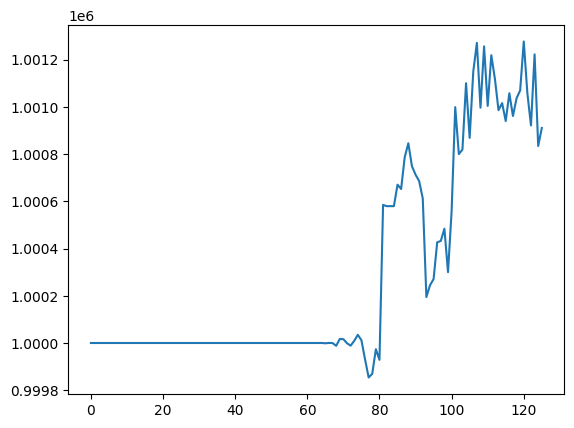

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.001821
Cumulative returns     0.000910
Annual volatility      0.001982
Sharpe ratio           0.926020
Calmar ratio           2.799627
Stability              0.656873
Max drawdown          -0.000650
Omega ratio            1.282138
Sortino ratio          1.512144
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.276819
Daily value at risk   -0.000242
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="MANU", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (125, 8)
Annual return           3.173721
Cumulative returns      1.031418
Annual volatility       0.595254
Sharpe ratio            2.699125
Calmar ratio           17.122287
Stability               0.701148
Max drawdown           -0.185356
Omega ratio             1.847425
Sortino ratio           7.297180
Skew                         NaN
Kurtosis                     NaN
Tail ratio              1.607815
Daily value at risk    -0.068619
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (125, 8)


Start date,2022-07-29
End date,2023-01-27
Total months,6
,Backtest
Annual return,0.182%
Cumulative returns,0.091%
Annual volatility,0.198%
Sharpe ratio,0.93
Calmar ratio,2.80
Stability,0.66
Max drawdown,-0.065%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.07,2022-12-02,2022-12-09,2022-12-21,14
1,0.04,2023-01-20,2023-01-26,NaT,NaN
2,0.03,2022-12-30,2023-01-12,2023-01-20,16
3,0.02,2022-12-27,2022-12-28,2022-12-29,3
4,0.02,2022-12-21,2022-12-22,2022-12-27,5


Stress Events,mean,min,max
New Normal,0.00%,-0.04%,0.07%


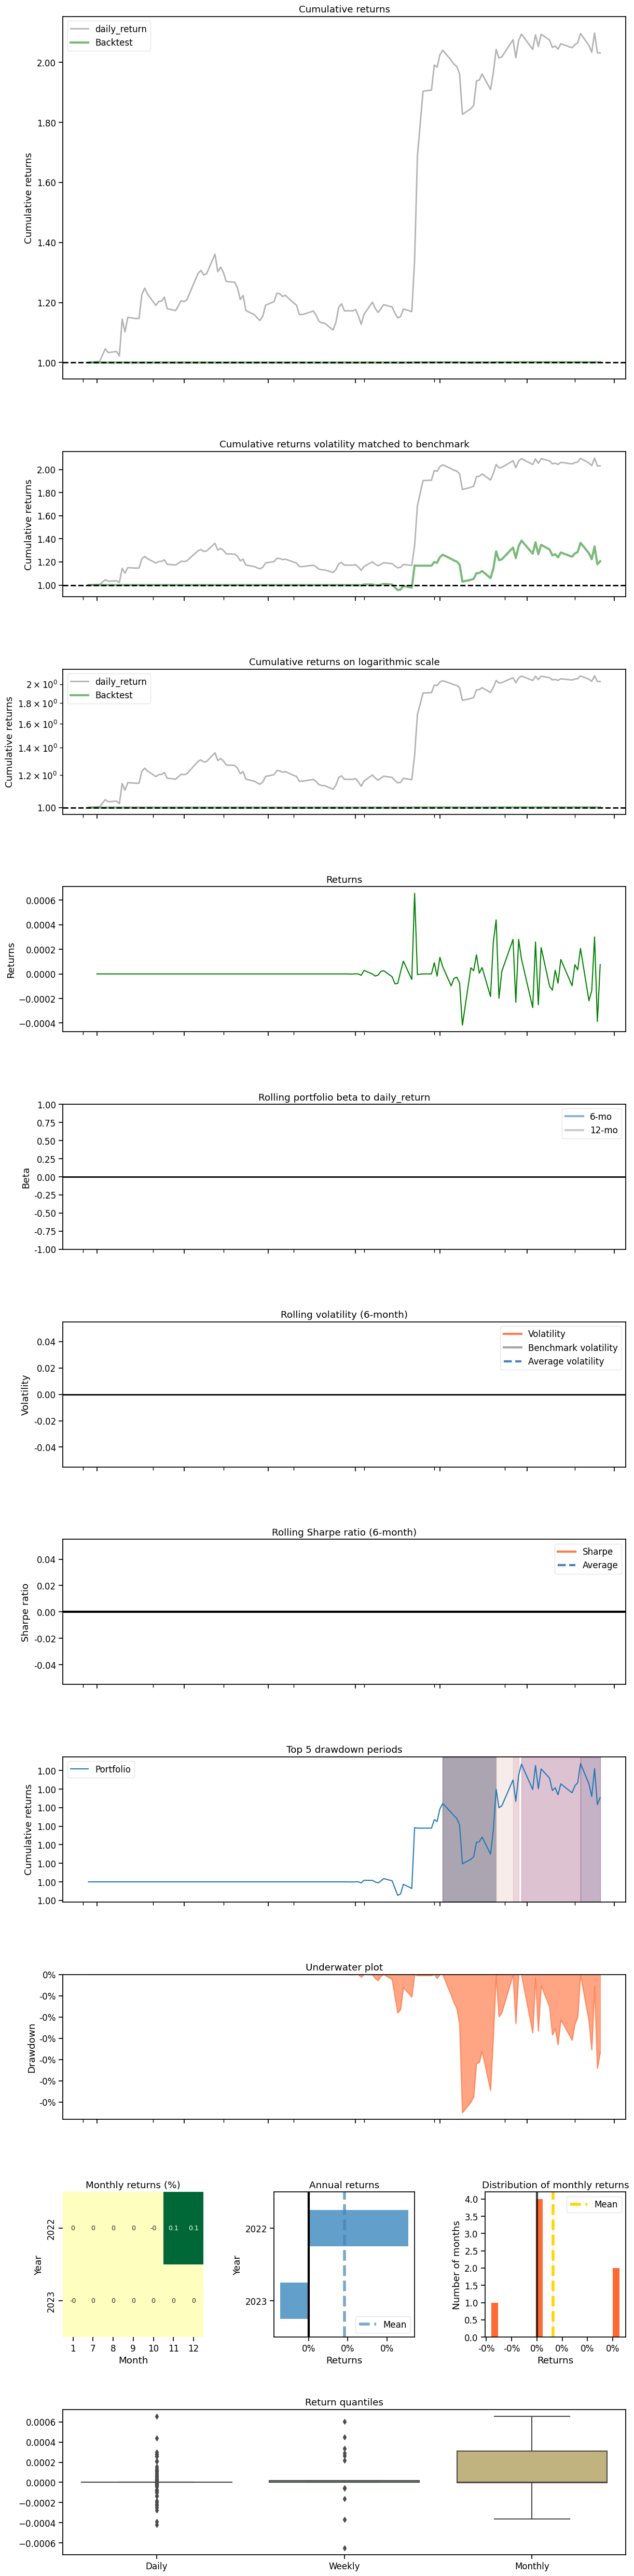

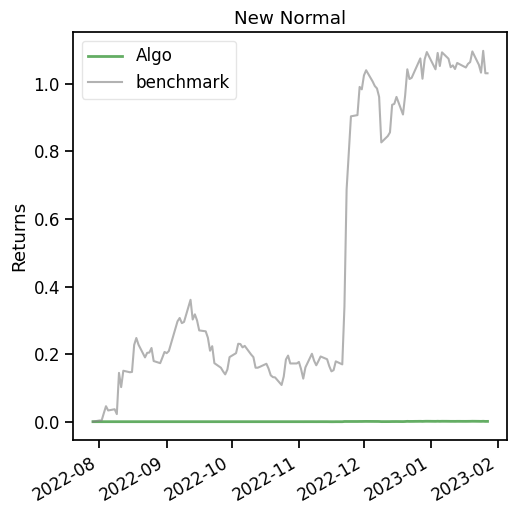

In [ ]:

print("==============Compare to DJIA===========")
%matplotlib inline
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])